In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score
import glob
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # The dataset is saved inside my google drive 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Extracting data in DataFrame format
main_path = '/content/drive/MyDrive/קורס למידה עמוקה/DATA/chest_xray'


train_path = os.path.join(main_path,'train')
test_path=os.path.join(main_path,'test')

train_normal = glob.glob(train_path+'/NORMAL/*.jpeg')
train_pneumonia = glob.glob(train_path+'/PNEUMONIA/*.jpeg')

test_normal = glob.glob(test_path+'/NORMAL/*.jpeg')
test_pneumonia = glob.glob(test_path+'/PNEUMONIA/*.jpeg')

train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]


In [ ]:
print(df_train.head())
print(f'Number of pictures in Train dataset: {len(df_train)}')

    class                                              image
0  Normal  /content/drive/MyDrive/קורס למידה עמוקה/DATA/c...
1  Normal  /content/drive/MyDrive/קורס למידה עמוקה/DATA/c...
2  Normal  /content/drive/MyDrive/קורס למידה עמוקה/DATA/c...
3  Normal  /content/drive/MyDrive/קורס למידה עמוקה/DATA/c...
4  Normal  /content/drive/MyDrive/קורס למידה עמוקה/DATA/c...
Number of pictures in Train dataset: 5216


In [ ]:
print(df_test.head())
print(f'Number of pictures in Test dataset: {len(df_test)}')

    class                                              image
0  Normal  /content/drive/MyDrive/קורס למידה עמוקה/DATA/c...
1  Normal  /content/drive/MyDrive/קורס למידה עמוקה/DATA/c...
2  Normal  /content/drive/MyDrive/קורס למידה עמוקה/DATA/c...
3  Normal  /content/drive/MyDrive/קורס למידה עמוקה/DATA/c...
4  Normal  /content/drive/MyDrive/קורס למידה עמוקה/DATA/c...
Number of pictures in Test dataset: 624


In [ ]:
# Splitting train dataframe to train(90%) and validation(10%)
train_df, val_df = train_test_split(df_train, test_size = 0.1, random_state = 42, stratify = df_train['class'])

In [ ]:
print(f'Number of pictures in Validation dataset: {len(val_df)}')
print(f'Number of pictures in Train dataset: {len(train_df)}')

Number of pictures in Validation dataset: 522
Number of pictures in Train dataset: 4694


In [ ]:
# Preproccesing data
batch_size = 124

train_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (224, 224),
                                             class_mode = 'binary',
                                             color_mode = 'rgb',
                                             batch_size = batch_size,
                                             shuffle=True,
                                             seed = 42)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                        x_col = 'image',
                                        y_col = 'class',
                                        target_size = (224, 224),
                                        class_mode = 'binary',
                                        color_mode = 'rgb',
                                        batch_size = batch_size,
                                        shuffle=True,
                                        seed = 42)

ds_test = test_datagen.flow_from_dataframe(df_test,
                                        x_col = 'image',
                                        y_col = 'class',
                                        target_size = (224, 224),
                                        class_mode = 'binary',
                                        color_mode = 'rgb',
                                        batch_size = 1,
                                        shuffle = False)

print(ds_train.image_shape)

Found 4694 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
(224, 224, 3)


**Transfer learning**

VGG16

In [ ]:
pre_trained_model = tf.keras.applications.vgg16.VGG16(input_shape = (224, 224, 3), 
                                include_top = False,
                                weights = 'imagenet')

pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
for layer in pre_trained_model.layers:
      if layer.name == 'block5_conv2' or layer.name == 'block5_conv3':
        layer.trainable = True
      else:
        layer.trainable = False

In [ ]:
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)                  
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
epochs = 15 # Run tf.keras.backend.clear_session() in the last cell before running ___.fit

model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate=1e-5), metrics='accuracy')

history = model.fit(ds_train, batch_size = batch_size, epochs = epochs, validation_data=ds_val)

Epoch 1/15
38/38 [==============================] - 153s 3s/step - loss: 0.3460 - accuracy: 0.8513 - val_loss: 0.1550 - val_accuracy: 0.9579
Epoch 2/15
38/38 [==============================] - 82s 2s/step - loss: 0.1375 - accuracy: 0.9497 - val_loss: 0.0939 - val_accuracy: 0.9770
Epoch 3/15
38/38 [==============================] - 82s 2s/step - loss: 0.0898 - accuracy: 0.9695 - val_loss: 0.0733 - val_accuracy: 0.9789
Epoch 4/15
38/38 [==============================] - 84s 2s/step - loss: 0.0657 - accuracy: 0.9798 - val_loss: 0.0552 - val_accuracy: 0.9847
Epoch 5/15
38/38 [==============================] - 82s 2s/step - loss: 0.0563 - accuracy: 0.9815 - val_loss: 0.0496 - val_accuracy: 0.9808
Epoch 6/15
38/38 [==============================] - 84s 2s/step - loss: 0.0453 - accuracy: 0.9853 - val_loss: 0.0451 - val_accuracy: 0.9808
Epoch 7/15
38/38 [==============================] - 81s 2s/step - loss: 0.0380 - accuracy: 0.9889 - val_loss: 0.0422 - val_accuracy: 0.9866
Epoch 8/15
38/38 [=

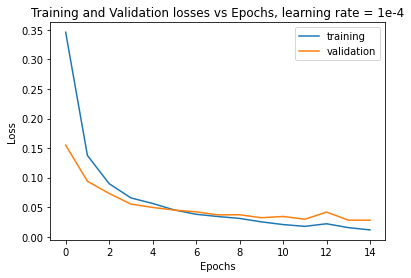

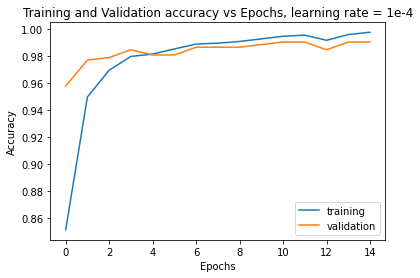

In [ ]:
# plot training and validation Loss/Accuracy vs Epochs
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Training and Validation losses vs Epochs, learning rate = 1e-5') 
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Training and Validation accuracy vs Epochs, learning rate = 1e-5') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(ds_test)
print(f"Test accuracy: {test_accuracy*100}%, Test loss: {test_loss}")

624/624 [==============================] - 24s 37ms/step - loss: 1.0268 - accuracy: 0.7804
Test accuracy: 78.04487347602844%, Test loss: 1.0267598628997803


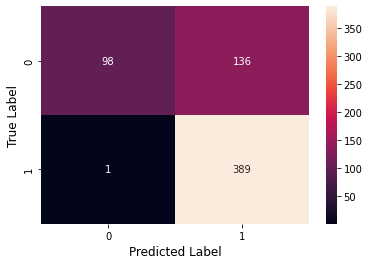

In [ ]:
import seaborn as sns

num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

ds_test.reset()
predictions = model.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

confusion_matrix = confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [ ]:
Recall = "{:.2f}".format(recall_score(Y_test, pred_labels))
Precision = "{:.2f}".format(precision_score(Y_test, pred_labels))
print(f'Recall score is: {Recall}')
print(f'Precision score is: {Precision}')

Recall score is: 1.00
Precision score is: 0.74


Resnet50

In [ ]:
pre_trained_model_Res = tf.keras.applications.resnet50.ResNet50(input_shape = (224, 224, 3), 
                                include_top = False,
                                weights = 'imagenet')

pre_trained_model_Res.summary()

94781440/94765736 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
for layer in pre_trained_model_Res.layers:
      if layer.name == 'conv5_block3_2_conv' or layer.name == 'conv5_block3_1_conv':
        layer.trainable = True
      else:
        layer.trainable = False

In [ ]:
x = layers.Flatten()(pre_trained_model_Res.output)
x = layers.Dense(256, activation='relu')(x)

x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

# Compile
modelRes = tf.keras.Model(pre_trained_model_Res.input, outputs)

modelRes.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
epochs = 15 # Run tf.keras.backend.clear_session() in the last cell before running ___.fit

modelRes.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate=1e-5), metrics='accuracy')

historyRes = modelRes.fit(ds_train, batch_size = batch_size, epochs = epochs, validation_data=ds_val)

Epoch 1/15
38/38 [==============================] - 108s 2s/step - loss: 0.6185 - accuracy: 0.7073 - val_loss: 0.5004 - val_accuracy: 0.7433
Epoch 2/15
38/38 [==============================] - 90s 2s/step - loss: 0.4508 - accuracy: 0.7846 - val_loss: 0.3930 - val_accuracy: 0.8142
Epoch 3/15
38/38 [==============================] - 85s 2s/step - loss: 0.3751 - accuracy: 0.8264 - val_loss: 0.3677 - val_accuracy: 0.8103
Epoch 4/15
38/38 [==============================] - 83s 2s/step - loss: 0.3388 - accuracy: 0.8483 - val_loss: 0.3350 - val_accuracy: 0.8295
Epoch 5/15
38/38 [==============================] - 85s 2s/step - loss: 0.2956 - accuracy: 0.8690 - val_loss: 0.2895 - val_accuracy: 0.8793
Epoch 6/15
38/38 [==============================] - 82s 2s/step - loss: 0.2662 - accuracy: 0.8933 - val_loss: 0.2608 - val_accuracy: 0.8966
Epoch 7/15
38/38 [==============================] - 83s 2s/step - loss: 0.2319 - accuracy: 0.9071 - val_loss: 0.2308 - val_accuracy: 0.9215
Epoch 8/15
38/38 [=

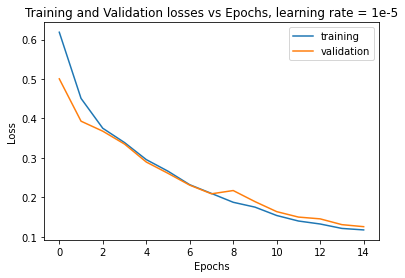

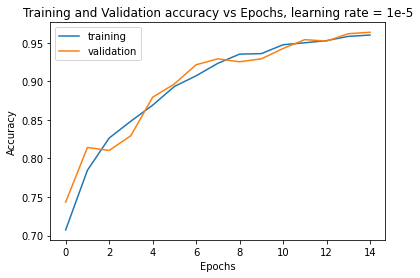

In [ ]:
# plot training and validation Loss/Accuracy vs Epochs
plt.figure(1)
plt.plot(historyRes.history['loss'])
plt.plot(historyRes.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Training and Validation losses vs Epochs, learning rate = 1e-5') 
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure(2)
plt.plot(historyRes.history['accuracy'])
plt.plot(historyRes.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Training and Validation accuracy vs Epochs, learning rate = 1e-5') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

In [ ]:
test_loss, test_accuracy = modelRes.evaluate(ds_test)

624/624 [==============================] - 32s 51ms/step - loss: 0.5619 - accuracy: 0.7628


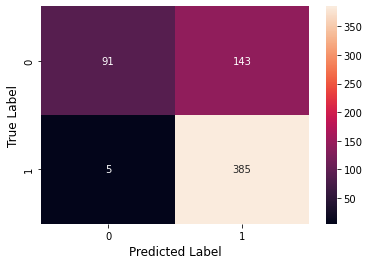

In [ ]:
import seaborn as sns

num_label = {'Normal':0, 'Pneumonia':1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

ds_test.reset()
predictions = modelRes.predict(ds_test,steps=len(ds_test),verbose=0)
pred_labels = np.where(predictions > 0.5, 1,0)

cm = confusion_matrix(Y_test,pred_labels)
sns.heatmap(cm, annot=True, fmt='d')

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

plt.show()

In [ ]:
Recall = "{:.2f}".format(recall_score(Y_test, pred_labels))
Precision = "{:.2f}".format(precision_score(Y_test, pred_labels))
print(f'Recall score is: {Recall}')
print(f'Precision score is: {Precision}')

Recall score is: 0.99
Precision score is: 0.73


Part 2: VGG16

In [ ]:
pre_trained_modelVGG2 = tf.keras.applications.vgg16.VGG16(input_shape = (224, 224, 3), 
                                include_top = False,
                                weights = 'imagenet')

pre_trained_modelVGG2.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
for layer in pre_trained_modelVGG2.layers: 
      if layer.name == 'block3_conv1' or layer.name == 'block3_conv2':
        layer.trainable = True
      else:
        layer.trainable = False

In [ ]:
last_layer = pre_trained_modelVGG2.get_layer('block5_pool')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)                  
x = layers.Dense(1, activation='sigmoid')(x)           

model2VGG = Model(pre_trained_modelVGG2.input, x) 

model2VGG.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
epochs = 15 # Run tf.keras.backend.clear_session() in the last cell before running ___.fit

model2VGG.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate=1e-5), metrics='accuracy')

history2VGG = model2VGG.fit(ds_train, batch_size = batch_size, epochs = epochs, validation_data=ds_val)

Epoch 1/15
38/38 [==============================] - 202s 4s/step - loss: 0.3871 - accuracy: 0.8262 - val_loss: 0.2016 - val_accuracy: 0.9387
Epoch 2/15
38/38 [==============================] - 92s 2s/step - loss: 0.1656 - accuracy: 0.9444 - val_loss: 0.1271 - val_accuracy: 0.9655
Epoch 3/15
38/38 [==============================] - 91s 2s/step - loss: 0.1092 - accuracy: 0.9644 - val_loss: 0.0871 - val_accuracy: 0.9693
Epoch 4/15
38/38 [==============================] - 91s 2s/step - loss: 0.0817 - accuracy: 0.9729 - val_loss: 0.0752 - val_accuracy: 0.9713
Epoch 5/15
38/38 [==============================] - 86s 2s/step - loss: 0.0704 - accuracy: 0.9781 - val_loss: 0.0888 - val_accuracy: 0.9674
Epoch 6/15
38/38 [==============================] - 87s 2s/step - loss: 0.0642 - accuracy: 0.9793 - val_loss: 0.0602 - val_accuracy: 0.9789
Epoch 7/15
38/38 [==============================] - 87s 2s/step - loss: 0.0532 - accuracy: 0.9834 - val_loss: 0.0568 - val_accuracy: 0.9789
Epoch 8/15
38/38 [=

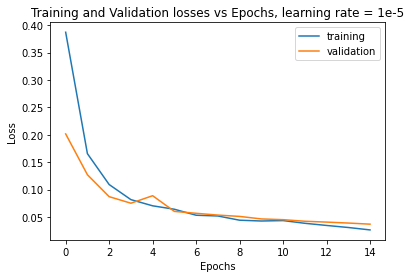

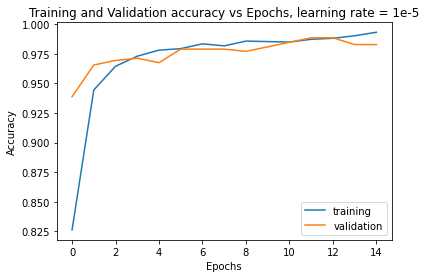

In [ ]:
# plot training and validation Loss/Accuracy vs Epochs
plt.figure(1)
plt.plot(history2VGG.history['loss'])
plt.plot(history2VGG.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Training and Validation losses vs Epochs, learning rate = 1e-5') 
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure(2)
plt.plot(history2VGG.history['accuracy'])
plt.plot(history2VGG.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Training and Validation accuracy vs Epochs, learning rate = 1e-5') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

In [ ]:
test_loss, test_accuracy = model2VGG.evaluate(ds_test)

624/624 [==============================] - 24s 37ms/step - loss: 0.7211 - accuracy: 0.8109


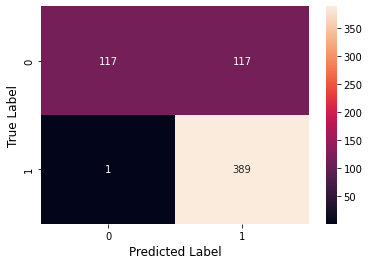

In [ ]:
import seaborn as sns

#num_label = {'Normal':0, 'Pneumonia':1}
#Y_test = df_test['class'].copy().map(num_label).astype('int')

#ds_test.reset()
predictions = model2VGG.predict(ds_test,steps=len(ds_test),verbose=0)
pred_labels = np.where(predictions > 0.5, 1,0)

cm = confusion_matrix(Y_test,pred_labels)
sns.heatmap(cm, annot=True, fmt='d')

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

plt.show()

In [ ]:
Recall = "{:.2f}".format(recall_score(Y_test, pred_labels))
Precision = "{:.2f}".format(precision_score(Y_test, pred_labels))
print(f'Recall score is: {Recall}')
print(f'Precision score is: {Precision}')

Recall score is: 1.00
Precision score is: 0.77


Part2: Resnet50

In [ ]:
pre_trained_model_Res2 = tf.keras.applications.resnet50.ResNet50(input_shape = (224, 224, 3), 
                                include_top = False,
                                weights = 'imagenet')

pre_trained_model_Res2.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
for layer in pre_trained_model_Res2.layers:
      if layer.name == 'conv3_block3_2_conv' or layer.name == 'conv3_block3_3_conv':
        layer.trainable = True
      else:
        layer.trainable = False

In [ ]:
x = layers.Flatten()(pre_trained_model_Res2.output)
x = layers.Dense(256, activation='relu')(x)

x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

# Compile
modelRes2 = tf.keras.Model(pre_trained_model_Res2.input, outputs)

modelRes2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
epochs = 15 # Run tf.keras.backend.clear_session() in the last cell before running ___.fit

modelRes2.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate=1e-5), metrics='accuracy')

historyRes2 = modelRes2.fit(ds_train, batch_size = batch_size, epochs = epochs, validation_data=ds_val)

Epoch 1/15
38/38 [==============================] - 112s 3s/step - loss: 0.6127 - accuracy: 0.7135 - val_loss: 0.4898 - val_accuracy: 0.7452
Epoch 2/15
38/38 [==============================] - 93s 2s/step - loss: 0.4608 - accuracy: 0.7686 - val_loss: 0.4081 - val_accuracy: 0.7950
Epoch 3/15
38/38 [==============================] - 93s 2s/step - loss: 0.3932 - accuracy: 0.8200 - val_loss: 0.3770 - val_accuracy: 0.8065
Epoch 4/15
38/38 [==============================] - 93s 2s/step - loss: 0.3508 - accuracy: 0.8447 - val_loss: 0.3439 - val_accuracy: 0.8602
Epoch 5/15
38/38 [==============================] - 92s 2s/step - loss: 0.3288 - accuracy: 0.8524 - val_loss: 0.3512 - val_accuracy: 0.8238
Epoch 6/15
38/38 [==============================] - 93s 2s/step - loss: 0.2996 - accuracy: 0.8718 - val_loss: 0.2995 - val_accuracy: 0.8793
Epoch 7/15
38/38 [==============================] - 92s 2s/step - loss: 0.2836 - accuracy: 0.8801 - val_loss: 0.2902 - val_accuracy: 0.8697
Epoch 8/15
38/38 [=

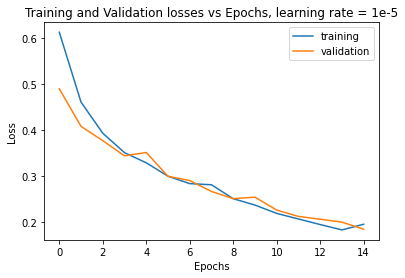

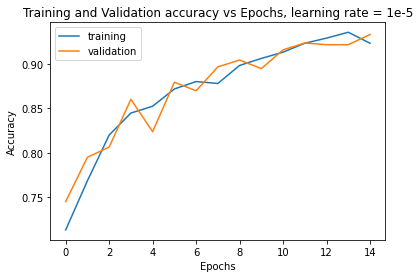

In [ ]:
# plot training and validation Loss/Accuracy vs Epochs
plt.figure(1)
plt.plot(historyRes2.history['loss'])
plt.plot(historyRes2.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Training and Validation losses vs Epochs, learning rate = 1e-5') 
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure(2)
plt.plot(historyRes2.history['accuracy'])
plt.plot(historyRes2.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Training and Validation accuracy vs Epochs, learning rate = 1e-5') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

In [ ]:
test_loss, test_accuracy = modelRes2.evaluate(ds_test)

624/624 [==============================] - 29s 47ms/step - loss: 0.4976 - accuracy: 0.7692


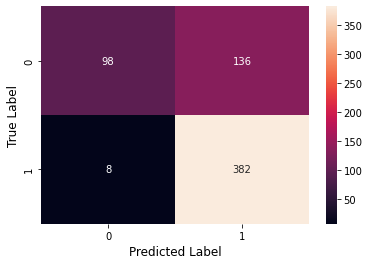

In [ ]:
import seaborn as sns

#num_label = {'Normal':0, 'Pneumonia':1}
#Y_test = df_test['class'].copy().map(num_label).astype('int')

#ds_test.reset()
predictions = modelRes2.predict(ds_test,steps=len(ds_test),verbose=0)
pred_labels = np.where(predictions > 0.5, 1,0)

cm = confusion_matrix(Y_test,pred_labels)
sns.heatmap(cm, annot=True, fmt='d')

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

plt.show()

In [ ]:
Recall = "{:.2f}".format(recall_score(Y_test, pred_labels))
Precision = "{:.2f}".format(precision_score(Y_test, pred_labels))
print(f'Recall score is: {Recall}')
print(f'Precision score is: {Precision}')

Recall score is: 0.98
Precision score is: 0.74


In [ ]:
tf.keras.backend.clear_session() # Run cell before __.fit command